LASSO REGRESSION (L1 REGULARIZATION)
====================================
Lasso (Least Absolute Shrinkage and Selection Operator) uses L1 regularization.
It adds a penalty proportional to the absolute value of coefficients.

Formula: Loss = RSS + α * Σ|βi|
where α is the regularization strength

L1 regularization can shrink coefficients to EXACTLY zero, effectively performing
feature selection. This makes Lasso useful for identifying the most important features.

In [1]:

# ============================================
# IMPORT LIBRARIES
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# ============================================
# LOAD AND EXPLORE DATASET
# ============================================
print("=" * 70)
print("LASSO REGRESSION (L1) - California Housing Dataset")
print("=" * 70)

# Load the SAME dataset for direct comparison
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='MedHouseValue')

print("\n1. DATASET OVERVIEW")
print("-" * 70)
print(f"Dataset shape: {X.shape}")
print(f"Using the same dataset as Linear and Ridge Regression")

LASSO REGRESSION (L1) - California Housing Dataset

1. DATASET OVERVIEW
----------------------------------------------------------------------
Dataset shape: (20640, 8)
Using the same dataset as Linear and Ridge Regression


In [4]:
# ============================================
# DATA PREPROCESSING
# ============================================
print("\n2. DATA PREPROCESSING")
print("-" * 70)

# Use SAME split (random_state=42) for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42  # Same seed as other models
)

# Feature Scaling - CRITICAL for Lasso
# Lasso is very sensitive to feature scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("✓ Features scaled (required for Lasso)")


2. DATA PREPROCESSING
----------------------------------------------------------------------
Training set size: 16512 samples
Testing set size: 4128 samples
✓ Features scaled (required for Lasso)


In [5]:
# ============================================
# FINDING OPTIMAL ALPHA
# ============================================
print("\n3. HYPERPARAMETER TUNING - Finding Optimal Alpha")
print("-" * 70)

# Alpha (α) controls regularization strength and feature selection
# Higher α → More features eliminated (coefficients = 0)
# Lower α → More features retained (less regularization)

# Test a range of alpha values
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

# LassoCV uses cross-validation to find optimal alpha
# max_iter increased to ensure convergence
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"Tested alpha values: {alphas}")
print(f"✓ Optimal alpha found: {optimal_alpha:.4f}")

# Analyze how many features are selected at different alphas
print(f"\nFeature Selection at Different Alphas:")
for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_scaled, y_train)
    n_features_used = np.sum(lasso_temp.coef_ != 0)
    r2 = lasso_temp.score(X_test_scaled, y_test)
    print(f"  α={alpha:7.4f} -> Features selected: {n_features_used}/{X.shape[1]}, Test R²: {r2:.4f}")


3. HYPERPARAMETER TUNING - Finding Optimal Alpha
----------------------------------------------------------------------
Tested alpha values: [0.0001, 0.001, 0.01, 0.1, 1, 10]
✓ Optimal alpha found: 0.0010

Feature Selection at Different Alphas:
  α= 0.0001 -> Features selected: 8/8, Test R²: 0.5759
  α= 0.0010 -> Features selected: 8/8, Test R²: 0.5769
  α= 0.0100 -> Features selected: 7/8, Test R²: 0.5816
  α= 0.1000 -> Features selected: 3/8, Test R²: 0.4814
  α= 1.0000 -> Features selected: 0/8, Test R²: -0.0002
  α=10.0000 -> Features selected: 0/8, Test R²: -0.0002


In [6]:
# ============================================
# MODEL TRAINING WITH OPTIMAL ALPHA
# ============================================
print("\n4. MODEL TRAINING")
print("-" * 70)

# Train Lasso with optimal alpha
model = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
model.fit(X_train_scaled, y_train)

print(f"✓ Lasso model trained with α = {optimal_alpha:.4f}")
print(f"\nModel intercept (β0): {model.intercept_:.4f}")

# Count non-zero coefficients (selected features)
n_features_selected = np.sum(model.coef_ != 0)
n_features_eliminated = np.sum(model.coef_ == 0)

print(f"\nFeature Selection Results:")
print(f"  Features selected: {n_features_selected}")
print(f"  Features eliminated: {n_features_eliminated}")
print(f"  Feature retention rate: {n_features_selected/len(model.coef_)*100:.1f}%")

# Display coefficients (including zeros)
print(f"\nModel coefficients (β1, β2, ..., βn):")
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Selected': ['Yes' if c != 0 else 'No' for c in model.coef_]
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))




4. MODEL TRAINING
----------------------------------------------------------------------
✓ Lasso model trained with α = 0.0010

Model intercept (β0): 2.0719

Feature Selection Results:
  Features selected: 8
  Features eliminated: 0
  Feature retention rate: 100.0%

Model coefficients (β1, β2, ..., βn):
   Feature  Coefficient Selected
  Latitude    -0.885822      Yes
 Longitude    -0.858093      Yes
    MedInc     0.849140      Yes
 AveBedrms     0.326050      Yes
  AveRooms    -0.281273      Yes
  HouseAge     0.123346      Yes
  AveOccup    -0.039890      Yes
Population    -0.001062      Yes


In [7]:
# ============================================
# PREDICTIONS
# ============================================
print("\n5. MAKING PREDICTIONS")
print("-" * 70)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("✓ Predictions completed")
print(f"\nSample predictions vs actual (first 5 test samples):")
comparison_df = pd.DataFrame({
    'Actual': y_test.values[:5],
    'Predicted': y_test_pred[:5],
    'Difference': y_test.values[:5] - y_test_pred[:5]
})
print(comparison_df.to_string(index=False))


5. MAKING PREDICTIONS
----------------------------------------------------------------------
✓ Predictions completed

Sample predictions vs actual (first 5 test samples):
 Actual  Predicted  Difference
0.47700   0.725923   -0.248923
0.45800   1.760909   -1.302909
5.00001   2.695707    2.304303
2.18600   2.837716   -0.651716
2.78000   2.598717    0.181283


In [8]:
# ============================================
# MODEL EVALUATION
# ============================================
print("\n6. MODEL EVALUATION")
print("-" * 70)

# Training metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("TRAINING SET METRICS:")
print(f"  Mean Squared Error (MSE):  {train_mse:.4f}")
print(f"  Root Mean Squared Error:   {train_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"  R² Score:                  {train_r2:.4f}")

print("\nTESTING SET METRICS:")
print(f"  Mean Squared Error (MSE):  {test_mse:.4f}")
print(f"  Root Mean Squared Error:   {test_rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  R² Score:                  {test_r2:.4f}")

print(f"\nOverfitting Check:")
print(f"  R² difference (Train - Test): {train_r2 - test_r2:.4f}")
if train_r2 - test_r2 > 0.1:
    print("  ⚠ Warning: Model may be overfitting!")
else:
    print("  ✓ Model is generalizing well (Lasso helps through feature selection)")


6. MODEL EVALUATION
----------------------------------------------------------------------
TRAINING SET METRICS:
  Mean Squared Error (MSE):  0.5180
  Root Mean Squared Error:   0.7197
  Mean Absolute Error (MAE): 0.5287
  R² Score:                  0.6125

TESTING SET METRICS:
  Mean Squared Error (MSE):  0.5545
  Root Mean Squared Error:   0.7446
  Mean Absolute Error (MAE): 0.5331
  R² Score:                  0.5769

Overfitting Check:
  R² difference (Train - Test): 0.0357
  ✓ Model is generalizing well (Lasso helps through feature selection)



7. VISUALIZATIONS
----------------------------------------------------------------------
✓ Visualizations saved as 'lasso_regression_analysis.png'


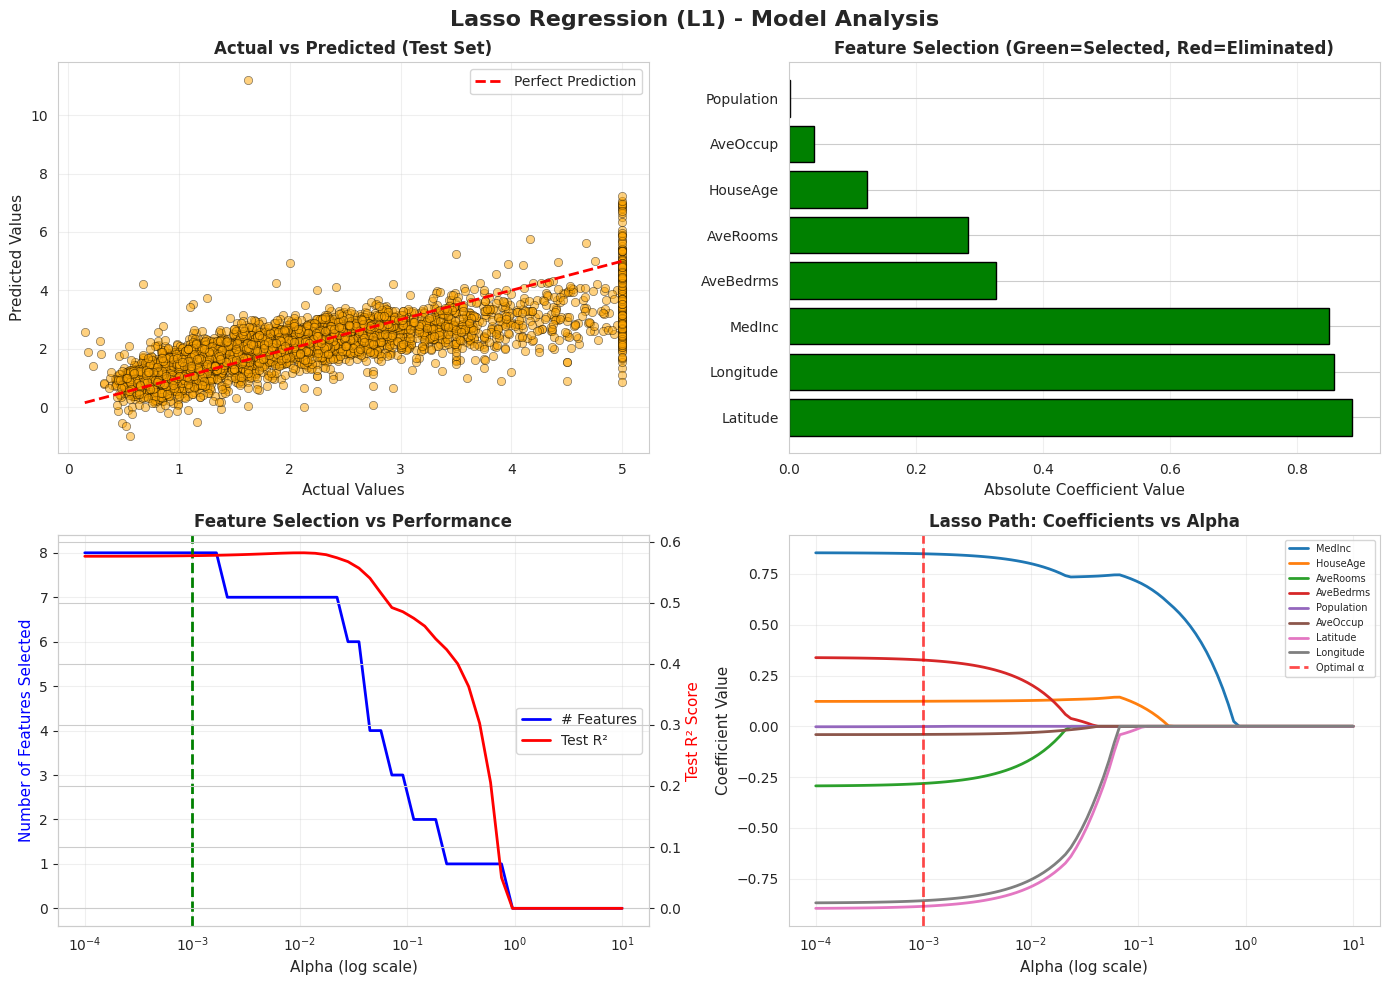

In [9]:
# ============================================
# VISUALIZATION
# ============================================
print("\n7. VISUALIZATIONS")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Lasso Regression (L1) - Model Analysis', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k',
                   linewidth=0.5, color='orange')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values', fontsize=11)
axes[0, 0].set_ylabel('Predicted Values', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Feature Selection - Coefficient Values
coef_plot_df = coef_df.copy()
colors = ['green' if c != 0 else 'red' for c in coef_plot_df['Coefficient']]
axes[0, 1].barh(coef_plot_df['Feature'], np.abs(coef_plot_df['Coefficient']),
                color=colors, edgecolor='black')
axes[0, 1].set_xlabel('Absolute Coefficient Value', fontsize=11)
axes[0, 1].set_title('Feature Selection (Green=Selected, Red=Eliminated)',
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Number of Features vs Alpha
feature_counts = []
test_r2_scores = []
for alpha in np.logspace(-4, 1, 50):
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_scaled, y_train)
    feature_counts.append(np.sum(lasso_temp.coef_ != 0))
    test_r2_scores.append(lasso_temp.score(X_test_scaled, y_test))

ax3_twin = axes[1, 0].twinx()
line1 = axes[1, 0].semilogx(np.logspace(-4, 1, 50), feature_counts,
                             'b-', linewidth=2, label='# Features')
line2 = ax3_twin.semilogx(np.logspace(-4, 1, 50), test_r2_scores,
                          'r-', linewidth=2, label='Test R²')
axes[1, 0].axvline(x=optimal_alpha, color='green', linestyle='--',
                   linewidth=2, label=f'Optimal α={optimal_alpha:.4f}')
axes[1, 0].set_xlabel('Alpha (log scale)', fontsize=11)
axes[1, 0].set_ylabel('Number of Features Selected', fontsize=11, color='b')
ax3_twin.set_ylabel('Test R² Score', fontsize=11, color='r')
axes[1, 0].set_title('Feature Selection vs Performance', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes[1, 0].legend(lines, labels, loc='center right')

# Plot 4: Lasso Path - Coefficient Evolution
axes[1, 1].set_title('Lasso Path: Coefficients vs Alpha', fontsize=12, fontweight='bold')
alphas_path = np.logspace(-4, 1, 100)
coefs = []
for alpha in alphas_path:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_scaled, y_train)
    coefs.append(lasso_temp.coef_)

coefs = np.array(coefs)
for i in range(coefs.shape[1]):
    axes[1, 1].semilogx(alphas_path, coefs[:, i], linewidth=2, label=X.columns[i])
axes[1, 1].axvline(x=optimal_alpha, color='red', linestyle='--',
                   linewidth=2, alpha=0.7, label=f'Optimal α')
axes[1, 1].set_xlabel('Alpha (log scale)', fontsize=11)
axes[1, 1].set_ylabel('Coefficient Value', fontsize=11)
axes[1, 1].legend(fontsize=7, loc='best')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lasso_regression_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualizations saved as 'lasso_regression_analysis.png'")

In [10]:
# ============================================
# SUMMARY AND INSIGHTS
# ============================================
print("\n8. SUMMARY")
print("=" * 70)
print("Lasso Regression (L1 Regularization) Summary:")
print(f"  • Optimal alpha (λ): {optimal_alpha:.4f}")
print(f"  • Test R² Score: {test_r2:.4f}")
print(f"  • Test RMSE: {test_rmse:.4f}")
print(f"  • Features selected: {n_features_selected}/{len(model.coef_)}")
print(f"  • Features eliminated: {n_features_eliminated}/{len(model.coef_)}")

print(f"\nSelected Features:")
selected_features = coef_df[coef_df['Selected'] == 'Yes']
for _, row in selected_features.iterrows():
    print(f"  • {row['Feature']}: {row['Coefficient']:.4f}")

print(f"\nKey Characteristics:")
print(f"  ✓ Performs automatic feature selection (L1 regularization)")
print(f"  ✓ More interpretable (fewer features)")
print(f"  ✓ Good for high-dimensional data")
print(f"  ✓ Robust to irrelevant features")
print(f"  ✗ May eliminate correlated features arbitrarily")
print("=" * 70)


8. SUMMARY
Lasso Regression (L1 Regularization) Summary:
  • Optimal alpha (λ): 0.0010
  • Test R² Score: 0.5769
  • Test RMSE: 0.7446
  • Features selected: 8/8
  • Features eliminated: 0/8

Selected Features:
  • Latitude: -0.8858
  • Longitude: -0.8581
  • MedInc: 0.8491
  • AveBedrms: 0.3260
  • AveRooms: -0.2813
  • HouseAge: 0.1233
  • AveOccup: -0.0399
  • Population: -0.0011

Key Characteristics:
  ✓ Performs automatic feature selection (L1 regularization)
  ✓ More interpretable (fewer features)
  ✓ Good for high-dimensional data
  ✓ Robust to irrelevant features
  ✗ May eliminate correlated features arbitrarily
